<a href="https://colab.research.google.com/github/tashinam/piano_generation/blob/main/piano_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%%capture
!pip install mido
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install wandb

In [22]:
%load_ext autoreload
%autoreload 2

In [13]:
%cd /content/piano_generation/
!git stash
!git pull
%cd

/content/piano_generation
No local changes to save
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/tashinam/piano_generation
   12bdb05..6c2a1f7  main       -> origin/main
Updating 12bdb05..6c2a1f7
Fast-forward
 models.py | 12 ++++++------
 1 file changed, 6 insertions(+), 6 deletions(-)
/root


In [1]:
import numpy as np
import mido
import os
import sys
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.autograd import Variable
from tqdm.notebook import tqdm
import pandas as pd
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
from torch.utils.data import Dataset, DataLoader
from piano_generation.models import *
from piano_generation.util import Maestro
wandb.login()

wandb: Currently logged in as: tashinam (use `wandb login --relogin` to force relogin)


True

# Model

### Set Parameters

### VAE

In [151]:
input_height = 88
cond_height = 3
# conductor_height = 4
# num_conductors = 5
# conductor_2_height = 5
# num_conductors_2 = 20
# conductor_3_height = 2
# num_conductors_3 = 8
seq_len = 100
odd = False
# input_height = 88+125
# cond_height = 0
# conductor_height = 10
# num_conductors = 10
# seq_len = 100
# odd = True
h=[1,4,5,5]
n=[1,1,4,20]
latent_dim = 256  
enc_hidden_dim = 256
hidden_dim= 256
cond_len = 0
input_len = seq_len + cond_len
teacher_forcing_ratio = 0

In [152]:
layers = 3
def check(h0,n0,h1,n1): 
  print(f'input size: {n0*h0}, height: {h1}, num: {n1}, output size: {n1*h1}')
  if n1==n0*h0:
    print(f'num=input {n1}={n0*h0}')
  else:
    print(f'WARNING! num!=input {n1}={n0*h0}') 

for a in range(layers):
  check(h[a],n[a],h[a+1],n[a+1])
  if a == layers-1:
    if seq_len == n[a+1]*h[a+1]:
      print(print(f'seq_len=output {seq_len}={n[a+1]*h[a+1]}'))
    else: 
      print(f'WARNING! seq_len!=output {seq_len}={n[a+1]*h[a+1]}')

input size: 1, height: 4, num: 1, output size: 4
num=input 1=1
input size: 4, height: 5, num: 4, output size: 20
num=input 4=4
input size: 20, height: 5, num: 20, output size: 100
num=input 20=20
seq_len=output 100=100
None


Text(0.92, 0.15, 'output size = 20x5 = 100')

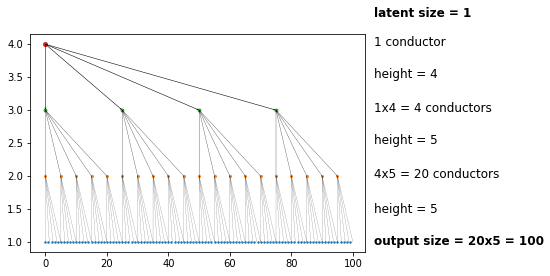

In [281]:
import matplotlib.pyplot as plt

plt.scatter(range(seq_len),np.ones(seq_len),s=2)
plt.scatter(np.arange(0,100,100/20), np.ones(20)*2,s=4)
plt.scatter(np.arange(0,100,100/4), np.ones(4)*3,s=8)
plt.scatter(np.arange(0,100,100/1), np.ones(1)*4,s=16)
plt.quiver(np.zeros(4), np.ones(4)*4, np.arange(0,100,100/4), np.ones(4)*-1, angles='xy', scale_units='xy', scale=1, width=0.0016)
plt.quiver(np.array([x for x in range(4) for y in range(5)])*25, np.ones(20)*3, list(np.linspace(0,20,5))*4, np.ones(20)*-1, angles='xy', scale_units='xy', scale=1, width=0.0008)
plt.quiver(np.array([x for x in range(20) for y in range(5)])*5, np.ones(100)*2, list(np.linspace(0,5,5))*20, np.ones(100)*-1, angles='xy', scale_units='xy', scale=1, width=0.0004)
plt.figtext(0.92, 0.94, 'latent size = 1', fontsize=12, fontweight='bold')
plt.figtext(0.92, 0.84, '1 conductor', fontsize=12)
plt.figtext(0.92, 0.73, 'height = 4', fontsize=12)
plt.figtext(0.92, 0.61, '1x4 = 4 conductors', fontsize=12)
plt.figtext(0.92, 0.50, 'height = 5', fontsize=12)
plt.figtext(0.92, 0.38, '4x5 = 20 conductors', fontsize=12)
plt.figtext(0.92, 0.26, 'height = 5', fontsize=12)
plt.figtext(0.92, 0.15, 'output size = 20x5 = 100', fontsize=12, fontweight='bold')

In [234]:
(np.array([x for x in range(5) for y in range(20)])*20)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80])

In [206]:
list(range(5))*5

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]

In [146]:
class VAE(pl.LightningModule):

    ###############################    
    ############ setup ############
    ###############################

    def __init__(self, input_dim=input_height, hidden_dim=hidden_dim, latent_dim=latent_dim):
        super().__init__()
        
        ### encoder & decoder networks
        self.encoder = lstm_encoder(input_size=input_dim, hidden_size=enc_hidden_dim, output_size=enc_hidden_dim, batch_size=batch_size)
        # self.vq = VectorQuantizerEMA(num_embeddings=1024, embedding_dim=8, commitment_cost=0.25, decay=0.99)
        # self.vq = VectorQuantizer(num_embeddings=1024, embedding_dim=4, commitment_cost=0.25)
        self.conductor = lstm_conductor(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)
        self.conductor_2 = lstm_conductor(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)
        self.conductor_3 = lstm_conductor(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)
        self.decoder = lstm_decoder(input_size=latent_dim, hidden_size=hidden_dim, output_size=latent_dim, batch_size=batch_size)

        ### latent distribution parameters
        self.fc_mu = nn.Linear((self.encoder.bidirectional+1)*enc_hidden_dim, latent_dim)
        self.fc_var = nn.Linear((self.encoder.bidirectional+1)*enc_hidden_dim, latent_dim)

        ### output 
        self.fc_out = nn.Linear(latent_dim, input_dim)
        # self.fc_cond = nn.Linear(latent_dim, latent_dim)
        # self.fc_out = nn.Linear(latent_dim, latent_dim)
        # self.tanh = nn.Tanh()
        # self.loss = nn.NLLLoss()
        # self.softmax = nn.LogSoftmax(dim=-1)

        ### variance for the Gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([-2.6]))

        ### kl-divergence weighting
        self.beta=1e-4

        ### save hyperparameters for lightning checkpoints
        self.save_hyperparameters()

    ### configure pytorch optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    ### reconstruction loss calculated as gaussian likelihood of drawing input vector from predicted vector 
    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        # return log_pxz.sum()
        return log_pxz.mean()

    ### reparameterization trick to add noise to variance for backpropagation
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return (eps * std) + mu

    ### kl-divergence calculated by monte-carlo estimation
    def kl_divergence(self, z, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std)) 
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        kl = (log_qzx - log_pz)
        kl = kl.mean(-1)
        return kl

    def conduct(self, prev_out, model, height, dim):
        outputs = torch.zeros((batch_size, height*dim, latent_dim), device=self.device) 
        for c in range(dim): 
            hidden = model.init_hidden(device=self.device)
            for s in range(height): 
                if s==0: 
                    input = prev_out[:,c].unsqueeze(1)
                output, hidden = model(input, hidden)
                outputs[:,(c*height)+s] = output.squeeze(1)
            if s<seq_len-1: 
                input = output

        return outputs



    ############################################    
    ############ training procedure ############
    ############################################

    def training_step(self, batch, batch_idx):
        
        ### separate input data and condition
        x = batch
        # x, cond = batch 
        if odd:
          x = x[:,:-1,:]

        ###### ENCODER ######

        ### reset encoder hidden and cell state each batch
        encoder_hidden = self.encoder.init_hidden(device=self.device)

        ### concatenate input and condition
        # input_cond = torch.zeros((batch_size, 1, input_height), device=self.device)
        # input_cond[:,:,:cond_height] = cond
        # x_input = torch.cat((input_cond,x),1) # concat along sequence dimension (1)
        x_input = x

        ### encode x to get the mu and variance parameters as a tensor 
        _, encoder_hidden = self.encoder(x_input, encoder_hidden)

        # get hidden state [0] but not cell state [1], swap batch to first index and get last layer only
        if self.encoder.bidirectional:
          x_encoded = encoder_hidden[0].transpose(0,1)[:,-2:,:].reshape(batch_size,1,self.encoder.hidden_size*2) # concat both directions of last hidden layer
        else:
          x_encoded = encoder_hidden[0].transpose(0,1)[:,-1,:].unsqueeze(1)
          
        

        ###### LATENT SPACE ######

        ### get latent space vector
        if vq:
          mu = self.fc_mu(x_encoded)
          vq_loss, z, perplexity, _ = self.vq(mu)
        else: 
          mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
          z = self.reparameterize(mu, log_var)

        # latent_cond = torch.zeros((batch_size, 1, hidden_dim), device=self.device)
        # latent_cond[:,:,:cond_height] = cond


        ###### CONDUCTOR ######

        #### code here for conductor model from musicvae paper

        # ### initialize output tensor
        # conductor_hidden = self.conductor.init_hidden(device=self.device)
        # conductor_outputs = torch.zeros((batch_size, conductor_height*num_conductors, latent_dim), device=self.device)

        # ### get hidden and cell state (but not output) for conditions
        # # for c in range(cond_len): 
        # # _, conductor_hidden = self.decoder(latent_cond, conductor_hidden) 

        # ### get outputs and hidden and cell state for rest of sequence
        # for s in range(conductor_height): 
        #   if s==0: # first input is always the latent vector
        #     conductor_input = z
          
        #   conductor_output, conductor_hidden = self.conductor(conductor_input, conductor_hidden)
        #   conductor_outputs[:,s] = conductor_output.squeeze(1)

        #   if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #     # conductor_input = F.one_hot(torch.argmax(conductor_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)
        #     conductor_input = conductor_output


        

        # ###### CONDUCTOR 2 ######
        # ### initialize output tensor
        # conductor_2_outputs = torch.zeros((batch_size, conductor_2_height*num_conductors_2, latent_dim), device=self.device) 
        # ### get outputs and hidden and cell state for rest of sequence
        # for c in range(num_conductors): 
        #   conductor_2_hidden = self.conductor_2.init_hidden(device=self.device)
        #   for s in range(conductor_height): 
        #       if s==0: # first input is always the latent vector
        #         conductor_2_input = conductor_outputs[:,c].unsqueeze(1)
        #       conductor_2_output, conductor_2_hidden = self.conductor_2(conductor_2_input, conductor_2_hidden)
        #       conductor_2_outputs[:,(c*conductor_height)+s] = conductor_2_output.squeeze(1)
        #   if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #     conductor_2_input = conductor_2_output


        


        # ###### CONDUCTOR 3 ######
        # ### initialize output tensor
        # conductor_3_outputs = torch.zeros((batch_size, conductor_3_height*num_conductors_3, latent_dim), device=self.device) 
        # ### get outputs and hidden and cell state for rest of sequence
        # for c in range(num_conductors_2): 
        #   conductor_3_hidden = self.conductor_3.init_hidden(device=self.device)
        #   for s in range(conductor_2_height): 
        #       if s==0: # first input is always the latent vector
        #         conductor_3_input = conductor_2_outputs[:,c].unsqueeze(1)
        #       conductor_3_output, conductor_3_hidden = self.conductor_3(conductor_3_input, conductor_3_hidden)
        #       conductor_3_outputs[:,(c*conductor_2_height)+s] = conductor_3_output.squeeze(1)
        #   if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #     conductor_3_input = conductor_3_output

        


        conductor_outputs = self.conduct(prev_out=z, model=self.conductor, height=2, dim=1) #4      
        conductor_2_outputs = self.conduct(prev_out=conductor_outputs, model=self.conductor_2, height=2, dim=2) #8
        # conductor_3_outputs = self.conduct(prev_out=conductor_2_outputs, model=self.conductor_2, height_in=2, height_out=2, dim_in=2, dim_out=4)
        decoder_outputs = self.conduct(prev_out=conductor_2_outputs, model=self.decoder, height=4, dim=4) #16
      

        # ###### DECODER ######

        # decoder_outputs = torch.zeros((batch_size, seq_len-odd, latent_dim), device=self.device)
        # zeros = torch.zeros((batch_size, 1, latent_dim), device=self.device)
        # # sub_x = torch.zeros((batch_size, conductor_height-1, latent_dim), device=self.device)

        # for c in range(num_conductors_2):
        #   ### initialize hidden state tensors
        #   decoder_hidden = self.decoder.init_hidden(device=self.device)

        #   ###### either TEACHER FORCING TENSORIZED ...
        #   # teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
        #   teacher_forcing = False
        #   if teacher_forcing:
        #     pass
        #     # # x_latent = torch.cat((latent_cond,z,x[:,1:,:]),1) # concat along sequence dimension (1)
        #     # # print(x.shape, x[:,100])
        #     # sub_x[:,:,:input_height] = x[:,(c*conductor_height)+1:((c+1)*conductor_height),:]
        #     # # print(f'start: {(c*conductor_height)+1}, stop: {((c+1)*conductor_height)}, len: {seq_len}')
        #     # # print(sub_x.shape, latent_cond.shape, conductor_outputs[:,c].shape)
        #     # # print(sub_x.shape, latent_cond.shape, conductor_outputs[:,c].unsqueeze(1).shape)
        #     # x_latent = torch.cat((latent_cond,conductor_outputs[:,c].unsqueeze(1),sub_x),1) # concat along sequence dimension (1)
        #     # # x_latent = torch.cat((conductor_outputs[:,c].unsqueeze(1),sub_x),1) # no latent
        #     # decoder_output, _ = self.decoder(x_latent, decoder_hidden)
            
        #     # # print(decoder_outputs[:,c*conductor_height:((c+1)*conductor_height),:].shape, decoder_output[:,cond_len:,:].shape)
        #     # decoder_outputs[:,c*conductor_height:((c+1)*conductor_height),:] = decoder_output[:,cond_len:,:] # remove outputs from conditional vectors
        #     # # decoder_outputs[:,c*conductor_height:((c+1)*conductor_height),:] = decoder_output # no latent

        #   else: 
        #     ### get hidden and cell state (but not output) for conditions
        #     # for c in range(cond_len): 
        #     # _, decoder_hidden = self.decoder(latent_cond, decoder_hidden) 

        #     ### get outputs and hidden and cell state for rest of sequence
        #     for s in range(conductor_2_height): 
        #       if s==0: # first input is always the latent vector
        #         decoder_input = conductor_2_outputs[:,c].unsqueeze(1)
        #         # decoder_input = torch.cat((conductor_outputs[:,c].unsqueeze(1),zeros), dim=2)
              
        #       decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        #       # decoder_output = self.output(decoder_output)
        #       # decoder_output = self.softmax(decoder_output)
        #       decoder_outputs[:,(c*conductor_2_height)+s] = decoder_output.squeeze(1)

        #       if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #         # decoder_input = F.one_hot(torch.argmax(decoder_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)
        #         # outmax = F.one_hot(torch.argmax(decoder_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)
        #         # decoder_input = torch.cat((conductor_outputs[:,c].unsqueeze(1), decoder_output), dim=2)
        #         # decoder_input = torch.cat((conductor_outputs[:,c].unsqueeze(1), zeros), dim=2)
        #         decoder_input = decoder_output

        # ###### WITHOUT CONDUCTOR
        # teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
        # if teacher_forcing:
        #   x_latent = torch.cat((latent_cond,z,x[:,1:,:]),1) # concat along sequence dimension (1)
        #   decoder_output, _ = self.decoder(x_latent, decoder_hidden)
        #   decoder_outputs = decoder_output[:,cond_len:,:]

        # else: 
        #   ### initialize output tensor
        #   decoder_outputs = torch.zeros((batch_size, seq_len, latent_dim), device=self.device)

        #   ### get hidden and cell state (but not output) for conditions
        #   # for c in range(cond_len): 
        #   _, decoder_hidden = self.decoder(latent_cond, decoder_hidden) 

        #   ### get outputs and hidden and cell state for rest of sequence
        #   for s in range(seq_len): 
        #     if s==0: # first input is always the latent vector
        #       decoder_input = z
            
        #     decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        #     decoder_outputs[:,s] = decoder_output.squeeze(1)

        #     if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #       decoder_input = F.one_hot(torch.argmax(decoder_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)

        
        # ###### or MIXED TEACHER FORCING within batch ...

        # ### initialize output tensor
        # decoder_outputs = torch.zeros((batch_size, seq_len, latent_dim), device=self.device)

        # ### get hidden and cell state (but not output) for conditions
        # # for c in range(cond_len): 
        # _, decoder_hidden = self.decoder(latent_cond, decoder_hidden) 

        # ### get outputs and hidden and cell state for rest of sequence
        # for s in range(seq_len): 
        #   if s==0: # first input is always the latent vector
        #     decoder_input = z
        #   decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        #   decoder_outputs[:,s] = decoder_output.squeeze(1)

        #   if s<seq_len-1: # subsequent inputs. Don't need to get another input after last decoding
        #     teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
        #     if teacher_forcing:
        #       decoder_input = x[:,s,:].unsqueeze(1)
        #     else:
        #       decoder_input = F.one_hot(torch.argmax(decoder_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)
        #       if not batch_idx%(50):
        #         print(f'y: {torch.argmax(decoder_output.squeeze(1),-1)}')
        #         print(f't: {torch.argmax(x[:,s,:],-1)}')


        ###### ... end  

        # x_hat = decoder_outputs[:,:,:input_height]
        x_hat = self.fc_out(decoder_outputs)
        # x_hat = self.softmax(x_hat)
        # x_hat = decoder_outputs
        if len(x_hat.shape)<3:
          x_hat = x_hat.unsqueeze(0)


        ###### LOSS ######  

        ### calculate reconstruction loss  
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        # print(x_hat.shape,x.shape)
        # recon_loss = self.loss(x_hat,x)
        
        ### calculate kl-divergence 
        if not vq:
          kl = self.kl_divergence(z, mu, log_var)
        # kl = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        ### calculate proportion of incorrect predictions
        arg_loss = ((torch.argmax(x,-1)-torch.argmax(x_hat,-1))**2).type(torch.FloatTensor)
        arg_loss_mean = arg_loss.mean()
        arg_loss_count = arg_loss.count_nonzero()/torch.numel(torch.argmax(x,-1))    

        # ### increment beta
        # if self.current_epoch >= 50 and self.beta <= 1: 
        #   self.beta+=10e-6 
        
        ### calculate elbo
        if vq: 
          elbo = (vq_loss - recon_loss).mean()
        else:
          elbo = (self.beta*kl.mean() - (recon_loss)).mean()

        ### gradient clipping 
        torch.nn.utils.clip_grad_norm_(self.parameters(), 0.25)


        ###### LOGGING ###### 

        if not batch_idx%(20):
          
          # ### lightning logging
          # self.log_dict({
          #     'elbo': elbo,
          #     'kl': kl.mean(),
          #     'recon_loss': recon_loss.mean()
          # })

          ### print statements
          print()
          print(f'epoch: {self.current_epoch}, step: {self.global_step}')
          if vq: 
            print(f'elbo: {elbo}, vq: {vq_loss.mean()}, recon: {recon_loss.mean()}')
          else:
            print(f'elbo: {elbo}, kl: {kl.mean()}, recon: {recon_loss.mean()}')
          print(f'mean: {arg_loss_mean}, count: {arg_loss_count}, log scale: {self.log_scale.data}')
          # print(f'teacher forcing: {teacher_forcing}')
          print(torch.argmax(x,-1)[:3])
          if odd:
            print(torch.tensor([[100 + x for x in range(num_conductors) for y in range(conductor_height)]]))
          else:
            print(torch.tensor([[100 + x for x in range(num_conductors_2) for y in range(conductor_2_height)]]))
          print(torch.argmax(x_hat,-1)[:3])
          
          

          ### weights and biases logging
          if vq:
            wandb.log({
                'mean': arg_loss_mean, 
                'count': arg_loss_count, 
                'elbo': elbo,
                'vq': vq_loss.mean(),
                'recon_loss': recon_loss.mean(),
                'log_scale': self.log_scale.data,
                'beta': self.beta,
                'epoch': self.current_epoch,
                'step': self.global_step
            })
          else:
              wandb.log({
                'mean': arg_loss_mean, 
                'count': arg_loss_count, 
                'elbo': elbo,
                'kl': kl.mean(),
                'recon_loss': recon_loss.mean(),
                'log_scale': self.log_scale.data,
                'beta': self.beta,
                'epoch': self.current_epoch,
                'step': self.global_step
            })
        
        
        return elbo

    def generate(self, condition=0):
      with torch.inference_mode():

        ### create condition       
        cond = torch.zeros(1,1,latent_dim)
        cond[:,:,condition]=1 # choose condition here
        cond = cond.repeat(batch_size,1,1)

        ### create random vector with zero mean and unit variance in shape of latent space
        ex = torch.zeros(1,latent_dim)
        p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex))
        z = p.rsample((batch_size,))
        decoder_input = z

        ### initialize decoder
        decoder_outputs = torch.zeros((batch_size, seq_len, latent_dim), device=self.device)
        decoder_hidden = self.decoder.init_hidden()

        ### NO TEACHER FORCING
        _, decoder_hidden = self.decoder(cond, decoder_hidden)
        for s in range(seq_len):
          decoder_output, decoder_hidden = vae.decoder(decoder_input, decoder_hidden)
          decoder_outputs[:,s] = decoder_output.squeeze(1)
          decoder_input = F.one_hot(torch.argmax(decoder_output,-1),latent_dim).type(torch.FloatTensor).to(self.device)

        ### get most likely notes greedily
        pred = decoder_outputs.argmax(axis=-1)

        return pred

### Training

In [110]:
wandb.init(project="piano_generation")

In [116]:
# checkpoint_callback = ModelCheckpoint(every_n_train_steps=1000)
torch.set_printoptions(linewidth=1000)
teacher_forcing_ratio=0
batch_size = 128
vq=False
checked=False
vae = VAE()
# trainer = pl.Trainer(gpus=1, max_epochs=100, callbacks=[checkpoint_callback], default_root_dir='/content/drive/MyDrive/Colab Notebooks/piano_generation/models')
trainer = pl.Trainer(gpus=1, max_epochs=100, default_root_dir='/content/drive/MyDrive/Colab Notebooks/piano_generation/models')
print(torch.cuda.get_device_name(0))
# data = Maestro('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/mido_100_short_combined.csv', '/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/mido_100_short_classes.csv')
# data = Maestro('/content/drive/MyDrive/Colab Notebooks/piano_generation/16_seqs.csv', '/content/drive/MyDrive/Colab Notebooks/piano_generation/16_conditions.csv')
# data = Maestro('/content/drive/MyDrive/Colab Notebooks/piano_generation/16_seqs.csv')
data = Maestro('/content/drive/MyDrive/Colab Notebooks/piano_generation/16_seqs.csv',input_height=input_height)
loader = DataLoader(data, batch_size=batch_size, num_workers=os.cpu_count(),drop_last=True,shuffle=True)
trainer.fit(vae, loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | encoder     | lstm_encoder   | 2.3 M 
1 | conductor   | lstm_conductor | 1.2 M 
2 | conductor_2 | lstm_conductor | 1.2 M 
3 | conductor_3 | lstm_conductor | 1.2 M 
4 | decoder     | lstm_decoder   | 1.2 M 
5 | fc_mu       | Linear         | 131 K 
6 | fc_var      | Linear         | 131 K 
7 | fc_out      | Linear         | 22.6 K
-----------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.227    Total estimated model params size (MB)


Tesla P100-PCIE-16GB


Training: 0it [00:00, ?it/s]

torch.Size([128, 1, 256]) torch.Size([128, 2, 256])
torch.Size([128, 2, 256]) torch.Size([128, 4, 256])
torch.Size([128, 4, 256]) torch.Size([128, 16, 256])

epoch: 0, step: 0
elbo: -0.5023810267448425, kl: 0.0009893275564536452, recon: 0.5023811459541321
mean: 826.97509765625, count: 1.0, log scale: tensor([-2.6000], device='cuda:0')
tensor([[84, 79, 84, 83, 84, 60, 77, 79, 79, 76, 65, 81, 79, 76, 74, 72],
        [67, 65, 77, 65, 65, 77, 69, 79, 72, 83, 62, 69, 72, 84, 84, 65],
        [84, 64, 76, 77, 76, 62, 71, 69, 69, 74, 60, 64, 72, 65, 71, 71]], device='cuda:0')
tensor([[100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 116, 116, 116,

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
def note2scale(x):
  n2s = {'0':60,'1':62,'2':64,'3':65,'4':67,'5':69,'6':71,
         '7':72,'8':74,'9':76,'10':77,'11':79,'12':81,'13':83,
         '14':84}
  return n2s.get(str(int(x)),x)

def scale2note(x):
  s2n = {'60':0,'62':1,'64':2,'65':3,'67':4,'69':5,'71':6,
         '72':7,'74':8,'76':9,'77':10,'79':11,'81':12,'83':13,
         '84':14}
  return s2n.get(str(int(x)),x)

def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) / ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    b = np.mean(ys) - m*np.mean(xs) 
    return m, b

In [ ]:
input_height=128
preds = vae.generate(condition=0)

In [ ]:
zeros = 0
ones = 0
twos = 0
for o in range(batch_size):
  scale = []
  for i in list(preds[o,:]):
    scale.append(scale2note(i))
  xs = np.array(range(seq_len))
  m, b = best_fit_slope_and_intercept(xs,scale)
  if m<-0.05:
    zeros+=1
  elif m>0.25:
    twos+=1
  else:
    ones+=1
  print(scale,m)
print(zeros,ones,twos)

[7, 7, 9, 5, 5, 5, 6, 3, 3, 8, 8, 7, 8, 8, 8, 3] 0.0058823529411764705
[7, 6, 9, 3, 8, 2, 6, 10, 6, 11, 12, 10, 9, 2, 7, 8] 0.11764705882352941
[7, 7, 2, 14, 9, 6, 3, 6, 6, 8, 9, 3, 9, 9, 2, 9] -0.022058823529411766
[3, 7, 5, 4, 8, 0, 3, 6, 4, 5, 5, 13, 9, 11, 14, 8] 0.5014705882352941
[4, 8, 14, 11, 9, 4, 11, 10, 1, 1, 0, 2, 3, 10, 10, 14] -0.07058823529411765
[2, 1, 8, 8, 6, 8, 7, 9, 2, 5, 2, 3, 3, 3, 3, 3] -0.18088235294117647
[11, 5, 7, 6, 10, 7, 6, 2, 2, 0, 1, 0, 3, 8, 8, 2] -0.3382352941176471
[10, 11, 11, 10, 6, 2, 3, 3, 3, 3, 8, 3, 6, 9, 9, 9] -0.1323529411764706
[9, 5, 9, 3, 4, 10, 8, 2, 2, 2, 3, 3, 0, 1, 2, 9] -0.31470588235294117
[0, 10, 13, 13, 9, 9, 10, 6, 2, 6, 9, 10, 11, 10, 8, 3] -0.060294117647058824
[7, 12, 8, 6, 5, 14, 10, 9, 4, 5, 6, 3, 2, 5, 8, 3] -0.375
[0, 6, 11, 11, 9, 2, 4, 14, 1, 2, 6, 13, 13, 9, 5, 8] 0.19411764705882353
[2, 2, 2, 9, 9, 6, 3, 9, 5, 4, 3, 8, 12, 2, 6, 11] 0.28088235294117647
[14, 11, 9, 12, 13, 11, 10, 6, 6, 9, 9, 2, 9, 14, 11, 12] -0.13529411

## Convert to MIDI

In [ ]:
new_pred = preds[:10]
new_pred.shape

In [ ]:
count = 1
composer='88_16_'

In [ ]:
for repr in new_pred:
  print(repr.shape)
  velocity = 0
  t = 0
  track = mido.MidiTrack()
  for r in repr:
    # rr = int(np.argmax(r))

    rr = int(r)
      
    if rr < 88:
      note = rr#+21
      print(note)
      t = int(mido.second2tick(0.25, 384, 500000))
      track.append(mido.Message('note_on', note=note, time=0, velocity=80))
      track.append(mido.Message('note_off', note=note, time=t, velocity=80))
      t = 0
    else: print('wtf!')

  mid_f = mido.MidiFile(type=1, ticks_per_beat=384)

  meta_track = mido.MidiTrack()
  meta_track.append(mido.MetaMessage('set_tempo', tempo=500000, time=0))
  meta_track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
  meta_track.append(mido.MetaMessage('end_of_track', time=1))

  mid_f.tracks.append(meta_track)
  mid_f.tracks.append(track)

  mid_f.save('/content/drive/MyDrive/Colab Notebooks/piano_generation/gen/'+composer+ str(count) +'.midi')
  count+=1

# Other

In [ ]:
# TEST
test_tensor = data[120].unsqueeze(0)
with torch.no_grad():
    z, _ = vae.encoder(test_tensor)
    _, quantized, _, _ = vae.vq_vae(z)
    pred, _ = vae.decoder(quantized)

In [ ]:
print(np.argmax(test_tensor,axis=2))
print(torch.argmax(pred,axis=-1))

tensor([[ 46,  88,  62,  89,  56,  88,  32,  90,  44, 103,  63,  88,  39,  89,  55,  88,  58,  89,  38,  88,  26,  90,  27, 102,  58,  91,  62,  91,  50,  99,  43,  91,  63,  90,  55,  88,  51, 100,  64,  89,  52,  89,  60,  89,  44,  88,  48, 102,  65,  88,  56,  89,  53, 102,  61,  88,  49,  89,  56,  89,  41,  90,  44, 101,  62,  88,  56,  88,  53,  89,  50, 100,  46,  89,  53,  88,  63,  89,  44,  88,  56,  88,  55,  89,  32,  88,  62,  89,  34,  88,  58, 102,  39,  88,  55,  89,  58,  88,  63,  88]])
tensor([ 46,  88,  62,  89,  56,  88,  32,  90,  44, 103,  63,  88,  39,  89,  55,  88,  58,  89,  38,  88,  26,  90,  27, 102,  58,  91,  62,  91,  50,  99,  43,  91,  63,  90,  55,  88,  51, 100,  64,  89,  52,  89,  60,  89,  44,  88,  48, 102,  65,  88,  56,  89,  53, 102,  61,  88,  49,  89,  56,  89,  41,  90,  44, 101,  62,  88,  56,  88,  53,  89,  50, 100,  46,  89,  53,  88,  63,  89,  44,  88,  56,  88,  55,  89,  32,  88,  62,  89,  34,  88,  58, 102,  39,  88,  55,  89,  

In [ ]:
z = (torch.rand(z.shape)-0.5)*1.5

In [ ]:
print(torch.min(z), torch.max(z))

tensor(-0.7499) tensor(0.7499)


In [ ]:
# SAMPLE
with torch.no_grad():
    _, quantized, _, _ = vae.vq_vae(z)
    pred, _ = vae.decoder(quantized)

In [ ]:
print(torch.argmax(pred,axis=-1))

tensor([ 25,  88, 100,  90, 100,  58, 100,  96, 100, 101, 100, 112,  37, 101, 100, 112, 100, 101, 100, 101, 100,  96, 100, 112, 100, 101,  47, 104, 100, 101, 100, 101, 100,  58,  47, 101, 100, 101, 100, 101, 100,  90, 100, 101, 100, 101, 100, 104, 100, 101, 100,  96, 100, 112, 100, 112, 100, 212, 100,  98, 100,  51, 100, 104, 100, 101, 100,  88, 100,  90,  47, 101, 100, 104, 100, 101,  47, 101, 100,  90, 100,  90,  62, 101, 100, 118, 100, 101, 100,  90,  47, 101, 100,  90, 100, 101, 100, 101, 100, 101])


## Training

## Load Model

In [ ]:
vae = VAE().load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/piano_generation/models/lightning_logs/version_312/checkpoints/epoch=24-step=16999.ckpt') 

In [ ]:
data = Maestro('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/mido_100_short_combined.csv')

In [ ]:
for param_tensor in vae.state_dict():
    print(param_tensor, "\t", vae.state_dict()[param_tensor])

## Verify

In [ ]:
# test_tensor = data[-1].unsqueeze(0)
# test_tensor = data[0][0]
# test_tensor = torch.swapaxes(test_tensor,0,1)
# # test_tensor = test_tensor.mean(axis=1)
# print(test_tensor.shape)
# # test_tensor2 = torch.zeros_like(test_tensor[:,0,:,:])
# print(test_tensor2.shape)                                
# for i in range(101):
#   test_tensor2[:,i,:] = test_tensor[:,i,i,:]
# print(data[0][0])
test_tensor = data[120][0].unsqueeze(0)#[:,:,:-10]
# cond = data[0][1].unsqueeze(0)
# print(test_tensor.shape, cond.shape)

In [ ]:
tt = np.argmax(test_tensor,axis=-1)[0]
min(tt)

tensor(17)

In [ ]:
np.nanmin(np.where(tt<88,tt,np.nan))

17.0

In [ ]:
np.where(# test_tensor = F.one_hot(torch.tensor([1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2]),413).unsqueeze(0).type(torch.FloatTensor)
# test_tensor.shape

In [ ]:
num_preds = 1
p = torch.distributions.Normal(torch.zeros_like(test_tensor), torch.ones_like(test_tensor)*0.01)
z2 = p.rsample((num_preds,))
test_tensor2 = test_tensor #+ z2.squeeze(0)

In [ ]:
test_tensor2.shape

torch.Size([1, 16, 88])

In [ ]:
# TES
batch_size = 1
with torch.no_grad():
    encoder_hidden = vae.encoder.init_hidden(batch_size)
    x_encoded, encoder_hidden = vae.encoder(test_tensor, encoder_hidden)
    # x_encoded, encoder_hidden = vae.encoder(test_tensor)
    # mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
    # z = vae.reparameterize(mu, log_var)
    z = x_encoded
    # z = torch.cat((z,cond),-1)
    decoder_hidden = vae.decoder.init_hidden(batch_size)
    pred, decoder_hidden = vae.decoder(z,decoder_hidden)
    # pred, _ = vae.decoder(z)
ones = torch.argmax(pred,axis=-1)

TypeError: ignored

In [ ]:
print(np.argmax(test_tensor,axis=-1)[0])
print(torch.argmax(pred,axis=-1))

tensor([65, 62,  0])
tensor([65, 62,  0])


In [ ]:

print(torch.argmax(pred,axis=-1))

tensor([28, 24, 44, 36, 24, 46, 36, 42, 24, 24, 36, 44, 42, 24, 44, 36])


In [ ]:
print(z.shape)

torch.Size([50, 50, 64])


In [ ]:
test_z.shape

torch.Size([50, 50, 64])

In [ ]:
p = 0.9
test_z = (((z[0]*p)+(z[-10]*(1-p)))).repeat(50,1,1)

In [ ]:
with torch.no_grad():
    decoder_hidden = vae.decoder.init_hidden(batch_size)
    new_pred, decoder_hidden = vae.decoder(test_z, decoder_hidden)

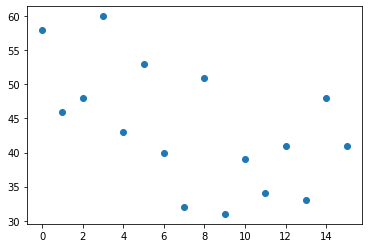

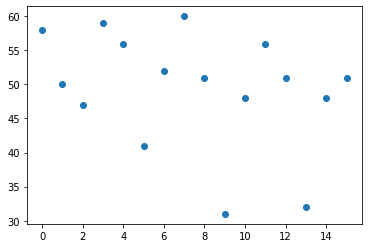

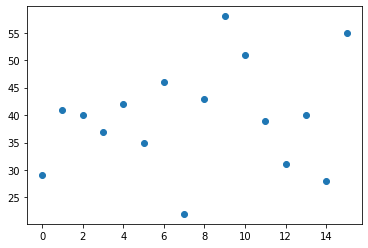

In [ ]:
plt.scatter(range(seq_len), np.argmax(pred,axis=-1)[0])
plt.show()
plt.scatter(range(seq_len), np.argmax(new_pred[0],axis=-1))
plt.show()
plt.scatter(range(seq_len), np.argmax(pred,axis=-1)[-10])
plt.show()

In [ ]:
np.argmax(test_av)

tensor([39, 29, 26, 41, 44, 28, 25, 43, 32, 27, 44, 24, 33, 42, 38, 22, 46, 50, 24, 21, 34, 58, 22, 19, 51,  6, 18,  8, 20, 10, 20, 11, 23, 13, 17, 56, 20, 41, 14, 32, 35, 13, 42, 59, 23, 12, 52, 60, 58, 34])

In [ ]:
ex = torch.zeros(100,256)
num_preds = 200
p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex))

looping = True

while looping: 

  time_errors = 0
  note_errors = 0
  total_errors = 0

  z2 = p.rsample((num_preds,))
  with torch.no_grad():
    decoder_hidden = vae.decoder.init_hidden(num_preds)
    pred, decoder_hidden = vae.decoder(z2, decoder_hidden)
      # pred, _ = vae.decoder(z2)

  pred = pred[10].unsqueeze(0)
  ones = pred.argmax(axis=-1).squeeze().tolist()

  for i,n in enumerate(ones):
    if i > 0:
      if n >= 88 and ones[i-1] >=88 and n != 212 and ones[i-1] != 212:
        time_errors += 1
      if n < 88 and ones[i-1] < 88: 
        note_errors += 1
  total_errors = time_errors + note_errors
  if total_errors <= 0:
    looping = False

  print(f'total: {total_errors}, time: {time_errors}, note: {note_errors}')     
ones        

total: 16, time: 10, note: 6
total: 17, time: 13, note: 4
total: 22, time: 11, note: 11
total: 15, time: 6, note: 9
total: 25, time: 16, note: 9
total: 8, time: 5, note: 3
total: 14, time: 3, note: 11


KeyboardInterrupt: ignored

In [ ]:
new_pred = pred

In [ ]:
z[0,1].shape

torch.Size([256])

In [ ]:
z[0].shape

torch.Size([50, 8])

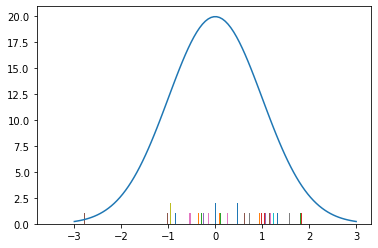

In [ ]:
import matplotlib.pyplot as plt
plt.hist(z[0],bins=50)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
sigma = 1
# sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma)*50)
plt.show()

## Generate

In [ ]:
# r_len=51

In [ ]:
# torch.ones_like(ex)*np.exp(vae.log_scale[0].item())

NameError: ignored

In [ ]:
ex = torch.zeros(1,88)
num_preds = 10
batch_size = 10
# cond = torch.zeros(2,1,88)
# cond[:,:,1]=2
# cond = torch.Tensor([[[0,0,1]]]).repeat(10,1,1)
cond = torch.zeros(1,1,88)
cond[:,:,1]=1
cond = cond.repeat(10,1,1)
print(cond.shape)
p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex))
z2 = p.rsample((num_preds,))
print(z2.shape)
# z2 = torch.cat((cond,z2),-1)
decoder_input=z2
print(decoder_input.shape)
# SAMPLE
decoder_outputs = torch.zeros(batch_size, seq_len, vae.decoder.hidden_size, device=vae.device)
with torch.no_grad():
  decoder_hidden = vae.decoder.init_hidden()
  ### NO TEACHER FORCING
  for s in range(seq_len+1):
    if s == 0:
       _, decoder_hidden = vae.decoder(cond, decoder_hidden)
    else:
      decoder_output, decoder_hidden = vae.decoder(decoder_input, decoder_hidden)
      decoder_input = F.one_hot(torch.argmax(decoder_output,-1),88).type(torch.FloatTensor).to(vae.device)
      decoder_outputs[:,s-1] = decoder_output.squeeze(1)
    # pred, decoder_hidden = vae.decoder(z2, decoder_hidden)
    # pred, _ = vae.decoder(z2)
pred = decoder_outputs
# pred = pred.unsqueeze(0)
ones = pred.argmax(axis=2)
scale = []
for i in list(ones[0,:]):
  scale.append(scale2note(i))
xs = np.array(range(10))
m, b = best_fit_slope_and_intercept(xs,scale)
print(scale,m)
# print(ones)

torch.Size([10, 1, 88])
torch.Size([10, 1, 88])
torch.Size([10, 1, 88])
[0, 6, 2, 4, 7, 6, 5, 2, 2, 1]
[0, 6, 2, 4, 7, 6, 5, 2, 2, 1] -0.10303030303030299


In [ ]:
# ex = torch.zeros(0,256)

# # num_preds = 1
# # p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex))
# # z2 = p.rsample((num_preds,))
# # print(z2.shape)
# # print(z2)
# # z_cond = torch.cat((z2,cond),-1) 
# # z3 = torch.cat((z,z_cond),1)
# # print(z3.shape, z3)
# # # SAMPLE
# # with torch.no_grad():
# #     pred, _ = vae.decoder(z3)

# num_preds = 1
# p = torch.distributions.Normal(torch.zeros_like(ex), torch.ones_like(ex)*.5)
# z = p.rsample((num_preds,))
# print(z.shape)
# print(z)


# # cond = torch.tensor(np.array([[1,0,0,0,0,0,0,0,0,0]]).repeat(50,0)).unsqueeze(0)
# # # print(cond.shape,z2.shape)
# # z_cond = torch.cat((z,cond),-1)



# # SAMPLE
# with torch.no_grad():
#     _, quantized, _, _ = vae.vq_vae(z)
#     pred, _ = vae.decoder(quantized)

# pred = pred.unsqueeze(0)
# ones = pred.argmax(axis=2)
# ones

In [ ]:
# pred[0][:].shape

In [ ]:
# pred2=pred+torch.distributions.Normal(0,0.1).rsample()

In [ ]:
# plt.bar(range(413),pred2[50],width=4)
# plt.show()

In [ ]:
# print(pred[0].max(axis=1))

In [ ]:
# test = np.argmax(test_tensor,axis=2)
# print(test)
# # ones[0]
# ons = 0
# offs = 0
# vs = 0
# ts = 0
# for n in test.flatten():
#   if n<127:
#     ons+=1
#   elif n<255:
#     offs+=1
#   elif n<287:
#     vs+=1
#   else:
#     ts+=1
# print(ons,offs,vs,ts)


In [ ]:
# pred = np.random.rand(10,249,413)

In [ ]:
rand = np.random.randint(0,213,(1,1,101))
new_pred = np.zeros_like(rand)
for j in range(new_pred.shape[0]):
  for i in range(new_pred.shape[1]):
    new_pred[j,i,rand[j,i]]=1
rand

IndexError: ignored

In [ ]:
ones = pred.argmax(axis=-1)
# ones = pred.argmax(axis=-1)
new_pred = np.zeros_like(pred)

In [ ]:
ones.shape

torch.Size([200, 101])

In [ ]:
# ones

In [ ]:
# for i in range(new_pred.shape[0]):
#   new_pred[i,ones[i]]=1
# with np.printoptions(linewidth=1000):
#     print(np.argmax(new_pred,axis=1))
# new_pred = np.expand_dims(new_pred,axis=0)

In [ ]:
for j in range(new_pred.shape[0]):
  for i in range(new_pred.shape[1]):
    new_pred[j,i,ones[j,i]]=1

In [ ]:
# with np.printoptions(linewidth=1000):
#   for i in range(10):
#     print(np.argmax(new_pred[i],axis=-1))

[ 46  88  62  89  88  88  32  90  41  39 114  88  39  89  55  88 107  89 100  88  37  90  32 102  45  91  58  91  42  46  90  91  29  90  92  88 102 102  60  89  38  89  60  89  41  88  89 102  56  88  56  65  90  22  89  65 129 132  58  98 134  38  63  41  30 130  64  19  41  97  68  11  28 107  22  20  88  41  44  35  74  99  53  90  66  52  99 103 113 123 136   9  93 111 113 104  95  49  18  31]


IndexError: ignored

In [ ]:
ones

tensor([[ 21, 125,  19,  ...,  24, 116,  22],
        [ 88,  46,  90,  ..., 117,  29, 119],
        [ 37,  88,  32,  ...,  20, 122,   8],
        ...,
        [ 90,  58, 103,  ...,  89,  65, 101],
        [ 20, 104,  25,  ...,  51,  91,  13],
        [ 93,  50,  96,  ...,  89,  36,  90]])

In [ ]:
np.argmax(new_pred,-1)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

## Convert to MIDI 413

In [ ]:
count = 3000
composer='long'

In [ ]:
for repr in ones:
  velocity = 0
  time = 0
  t = 0
  track = mido.MidiTrack()
  for r in repr:
    rr = int(r)
    # rr = int(np.argmax(r))

    # 413 different events
    # ----------------------
    # NOTE ON starts at 0
    # NOTE OFF starts at 128
    # TIME-SHIFT starts at 256
    # VELOCITY STARTS AT 381 

    if rr >=381:
      velocity = (rr-381)*4
      
    elif rr >=256:
      time += (rr-256)*8/1000
      t = int(mido.second2tick(time, 384, 500000))
    elif rr >=128:
      note = rr-128
      track.append(mido.Message('note_on', note=note, time=t, velocity=0))
      time = 0
      t = 0
    elif rr < 128:
      note = rr
      # print(t)
      # print(velocity)
      track.append(mido.Message('note_on', note=note, time=t, velocity=velocity))
      time = 0
      t = 0
    else: print('wtf!')

  mid_f = mido.MidiFile(type=1, ticks_per_beat=384)

  meta_track = mido.MidiTrack()
  meta_track.append(mido.MetaMessage('set_tempo', tempo=500000, time=0))
  meta_track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
  meta_track.append(mido.MetaMessage('end_of_track', time=1))

  mid_f.tracks.append(meta_track)
  mid_f.tracks.append(track)

  mid_f.save('/content/drive/MyDrive/Colab Notebooks/piano_generation/gen/'+composer+ str(count) +'.midi')
  count+=1

## Encode MIDI 413

In [ ]:
t_len = 100
r_len = t_len+1

# years = ['2009a','2014a','2013a','2018a','2017a','2008a','2015a','2006a','2011a','2004a','2009b','2014b','2013b','2018b','2017b','2008b','2015b','2006b','2011b','2004b']
years = ['32']

for year in tqdm(years):

  representations = []

  for midname in tqdm(os.listdir('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/'+year)):
    mid = mido.MidiFile('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/'+year+'/'+midname)

    i = 0
    total_time = 0
    time = 0
    representation = []

    last_v = 0
    last_event_time = 0

    for msg in mid:

      # 413 different events
      # ----------------------
      # NOTE ON starts at 0
      # NOTE OFF starts at 128
      # TIME-SHIFT starts at 256
      # VELOCITY STARTS AT 381 

      #print(msg.type, msg.time,'s ',msg.time*1000,'ms')

      # print(msg)


    # get time
      total_time+=msg.time*1000 
      time+=msg.time*1000
      # print(total_time, time)

      # check how many seconds elapsed
      r = time/1000
      # if greater than 1 second 
      if r > 1: 
        event = np.zeros(413)
        event[380]=1
        # then add a time_shift event for each second
        for i in range(int(r)):
          # print('time: ', 125, 380)
          representation.append(event)
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]
          time-=1000

      if msg.type=='note_on':
        # then we want to save a time event
        t = int(time/8)
        time -= (t*8)
        event = np.zeros(413)
        event[256+t]=1
        # print('time: ', t, 256+t)
        representation.append(event)
        if len(representation)==r_len:   
          representations.append(representation)
          representation=[]

        if msg.velocity == 0:
    # get note off
          # print('off: ', msg.note, 128+msg.note)
          event = np.zeros(413)
          event[128+msg.note]=1
          representation.append(event)
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]    
        else:
    # get velocity   
          # print('velocity: ', msg.velocity)
          v = msg.velocity//4
          if v != last_v:
            event = np.zeros(413)
            event[381+v]=1
          # print('velocity: ', v, 381+v)
          representation.append(event)
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]
          # print('velocity_bin: ', v)
    # get note on
          # print('on: ', msg.note, msg.note)
          event = np.zeros(413)
          event[msg.note]=1
          representation.append(event) 
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]

  rmax = np.argmax(np.array(representations),axis=2).astype(int)
  np.savetxt('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/mido_100_'+year+'.csv', rmax, fmt='%s', delimiter=',')

## Encode MIDI 213

In [ ]:
t_len = 100
r_len = t_len+1

# years = ['2009a','2014a','2013a','2018a','2017a','2008a','2015a','2006a','2011a','2004a','2009b','2014b','2013b','2018b','2017b','2008b','2015b','2006b','2011b','2004b']
years = ['0']

for year in tqdm(years):

  representations = []

  for midname in tqdm(os.listdir('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/'+year)):
    mid = mido.MidiFile('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/'+year+'/'+midname)

    i = 0
    total_time = 0
    time = 0
    representation = []

    last_v = 0
    last_event_time = 0

    for msg in mid:

      # 213 different events
      # ----------------------
      # NOTE ON starts at 0
      # TIME-SHIFT starts at 88

      #print(msg.type, msg.time,'s ',msg.time*1000,'ms')

      # print(msg)


    # get time
      total_time+=msg.time*1000 
      time+=msg.time*1000
      # print(total_time, time)

      # check how many seconds elapsed
      r = time/1000
      # if greater than 1 second 
      if r >= 1: 
        event = np.zeros(213)
        event[212]=1
        # then add a time_shift event for each second
        for i in range(int(r)):
          # print('time: ', 125, 380)
          representation.append(event)
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]
          time-=1000

      if msg.type=='note_on':

        if msg.velocity != 0:
          # then we want to save a time event
          t = int(time/8)
          time -= (t*8)
          event = np.zeros(213)
          event[88+t]=1
          representation.append(event)
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]

          # then we want to save a note on event
          event = np.zeros(213)
          event[msg.note-21]=1
          representation.append(event) 
          if len(representation)==r_len:   
            representations.append(representation)
            representation=[]

  rmax = np.argmax(np.array(representations),axis=2).astype(int)
  np.savetxt('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/mido_100_short'+year+'.csv', rmax, fmt='%s', delimiter=',')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
pd.read_csv('/content/drive/MyDrive/Colab Notebooks/piano_generation/maestro-v3.0.0/mido_100_short0.csv',header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,212,92,22,89,10,100,23,89,11,96,25,89,13,102,27,88,15,212,171,32,88,41,90,35,90,27,212,212,135,33,88,42,89,38,89,23,120,39,91,18,...,97,8,91,20,92,10,93,22,98,11,89,23,99,13,88,25,105,15,90,27,212,154,41,90,27,89,32,88,35,212,212,156,33,89,42,90,38,88,23,126
1,39,88,18,89,27,88,46,90,34,212,153,46,89,58,89,51,92,39,212,190,3,95,15,99,5,91,17,94,6,93,18,92,8,96,10,88,20,96,22,90,...,28,88,37,212,175,25,88,34,89,44,88,40,124,28,88,47,88,35,89,20,88,40,212,109,20,91,26,96,29,97,35,89,38,88,41,88,50,89,47,212
2,205,20,88,36,89,27,88,51,88,30,88,42,88,39,89,48,161,35,88,39,88,51,89,54,88,45,212,212,137,37,134,38,151,34,89,39,89,30,89,51,...,212,96,46,92,43,212,208,47,90,32,91,39,88,44,115,31,89,51,89,39,89,46,88,23,212,104,47,88,59,89,43,91,50,105,46,91,51,88,58,91
3,39,212,212,90,40,91,37,106,39,89,35,212,99,46,90,43,212,200,47,91,34,88,39,89,44,104,32,118,31,88,23,89,51,89,46,88,39,212,110,59,...,91,20,98,19,89,22,97,23,96,25,98,21,89,26,94,22,93,27,92,23,212,108,47,88,35,88,42,89,33,88,18,89,23,89,27,89,39,100,39,212
4,157,35,88,20,88,49,88,40,89,37,88,25,88,44,88,28,136,37,88,51,89,22,88,46,88,27,88,31,88,43,88,39,212,113,58,88,46,88,39,89,...,88,54,88,22,88,49,89,27,88,42,88,46,89,30,198,23,92,29,90,32,89,56,89,44,88,47,88,51,88,39,97,54,118,25,88,40,88,58,89,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,60,89,48,109,51,105,39,106,44,99,48,109,51,97,39,102,44,109,48,119,36,89,39,92,44,89,48,97,51,107,34,89,37,89,49,89,43,114,51,91,...,102,51,101,39,100,44,109,48,102,51,105,36,89,39,90,48,92,44,99,51,107,37,89,34,89,49,89,43,110,51,96,34,89,27,90,46,120,36,89,32
3946,90,48,92,44,93,51,113,39,103,44,107,48,100,51,103,39,102,44,111,48,105,51,105,36,89,48,89,39,93,44,99,51,112,49,91,37,89,43,90,34,...,48,117,36,99,39,108,44,103,48,109,36,100,39,107,44,105,48,105,36,101,39,111,44,105,48,107,36,100,39,120,44,113,47,108,19,88,35,102,39,108
3947,20,91,44,106,47,103,23,89,35,102,39,107,26,90,44,105,47,108,27,90,39,105,44,108,32,90,47,108,51,112,34,94,39,108,44,108,20,97,39,96,...,22,135,47,112,44,89,23,89,32,108,46,97,44,99,43,99,45,101,42,91,24,101,44,100,42,95,40,102,42,91,44,98,25,93,40,102,42,98,40,100
3948,39,96,42,101,39,90,27,101,40,98,39,98,37,102,40,100,28,89,37,101,40,104,37,89,28,89,32,99,40,104,35,89,30,88,27,101,40,102,30,89,...,95,27,89,23,90,32,101,40,101,32,89,27,89,23,100,40,108,25,88,22,88,31,173,52,89,34,88,37,88,49,88,31,88,40,88,46,212,165,51,101


## Convert to MIDI 213

In [ ]:
new_pred = np.expand_dims(new_pred[2],0)

NameError: ignored

In [ ]:
new_pred.shape

(1, 101, 413)

In [ ]:
pred

tensor([[[9.5289e-03, 8.9877e-03, 8.4953e-03,  ..., 9.9051e-03, 9.1890e-03, 5.8481e-03],
         [9.9495e-03, 1.0150e-02, 9.8334e-03,  ..., 9.0563e-03, 8.5269e-03, 1.1825e-02],
         [9.4802e-03, 7.4423e-03, 8.3112e-03,  ..., 1.0373e-02, 1.0604e-02, 1.2105e-02],
         ...,
         [9.9625e-03, 9.3065e-03, 9.5493e-03,  ..., 9.3143e-03, 1.0053e-02, 5.4974e-03],
         [9.6761e-03, 9.5058e-03, 9.6339e-03,  ..., 8.9657e-03, 8.9058e-03, 7.0971e-03],
         [9.5549e-03, 9.0121e-03, 8.7494e-03,  ..., 9.7650e-03, 1.0358e-02, 8.3889e-03]],

        [[9.5609e-03, 8.6016e-03, 9.6783e-03,  ..., 1.3353e-02, 1.1113e-02, 9.2699e-03],
         [9.8197e-03, 9.7993e-03, 9.0923e-03,  ..., 1.0240e-02, 1.1128e-02, 9.5561e-03],
         [9.6442e-03, 9.1745e-03, 9.3835e-03,  ..., 9.8386e-03, 9.3619e-03, 9.2946e-03],
         ...,
         [9.8440e-03, 1.0025e-02, 1.0209e-02,  ..., 9.6969e-03, 9.6437e-03, 9.3651e-03],
         [9.9268e-03, 9.8254e-03, 9.6369e-03,  ..., 9.7689e-03, 9.7611e-03, 1.47

In [ ]:
v

In [ ]:
ones = np.random.randint(0,213,(1,101))

In [ ]:
new_pred = ones[0]

In [ ]:
new_pred = new_pred.unsqueeze(0)
new_pred

tensor([[ 16, 138,  23,  90,  38,  90,  49,  95,  31, 116,  31, 114,  65, 117,  38,  88,  28,  89,  35, 114,  31, 118,  31, 101,  31, 119,  40,  89,  67,  88,  37,  92,  30, 111,  27, 116,  64, 119,  58, 113,  41,  92,  28,  89,  38,  92,  33, 110,  26, 116,  26, 115,  19,  88,  57,  90,  40, 116,  45,  89,  41,  88,  64, 116,  15,  93,  31, 123,  14, 104,  18,  88,  45,  91,  61, 120,  26, 118,  45,  89,  27,  88,  41,  90,  35, 111,  47, 109,  63,  90,  45,  89,  41,  91,  36, 108,  24, 117,  24, 116,  22]])

In [ ]:
new_pred

tensor([[ 27, 137,  49, 114,  29,  16,  35, 116, 141, 149, 141, 198,  28, 116,  29, 121,  49,  89,  35, 198,  14, 132,  54, 126,  54, 123,  31,  89,  27, 120,  49, 112,  54, 126,  58, 177,  58, 139, 184,  98,  41, 133,  43,  89,  37, 112,  60, 138,  64, 177,  64, 155,  49, 121,   8, 103,  65, 177,  34,  89,  41, 121,  58, 149,  64, 160,  64, 158,  43, 117,  43, 134,  34,  91,  60, 124,  64, 132,  34,  89,  43, 121,  41, 119,  35, 124,  64, 160, 123, 103,  34,  89,  41,  48,  39, 131,  37, 116,  37, 149,  18]])

In [ ]:
# new_pred=new_pred.squeeze(0)

In [ ]:
# new_pred = new_pred.unsqueeze(0)

In [ ]:
for repr in new_pred:
  print(repr.shape)
  velocity = 0
  time = 0
  t = 0
  track = mido.MidiTrack()
  for r in repr:
    # rr = int(np.argmax(r))

    rr = int(r)
    if rr >=88:
      time += (rr-88)*8/1000
      t = int(mido.second2tick(time, 384, 500000))
    elif rr < 88:
      note = rr+21
      print(t)
      print(note)
      # print(velocity)
      track.append(mido.Message('note_on', note=note, time=t, velocity=80))
      t = 0
      time = 0
    else: print('wtf!')

  mid_f = mido.MidiFile(type=1, ticks_per_beat=384)

  meta_track = mido.MidiTrack()
  meta_track.append(mido.MetaMessage('set_tempo', tempo=500000, time=0))
  meta_track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
  meta_track.append(mido.MetaMessage('end_of_track', time=1))

  mid_f.tracks.append(meta_track)
  mid_f.tracks.append(track)

  mid_f.save('/content/drive/MyDrive/Colab Notebooks/piano_generation/gen/'+composer+ str(count) +'.midi')
  count+=1

## 88 to MIDI

In [ ]:
count = 1
composer='88test_'

In [ ]:
new_pred = torch.argmax(test_tensor,axis=-1)

In [ ]:
new_pred = ones[-1].unsqueeze(0)

In [ ]:
new_pred = new_pred[-1].unsqueeze(0)

In [ ]:
new_pred.shape

torch.Size([1, 10])

In [ ]:
count = 1
composer='88test_'

for repr in new_pred:
  print(repr.shape)
  velocity = 0
  t = 0
  track = mido.MidiTrack()
  for r in repr:
    # rr = int(np.argmax(r))

    rr = int(r)
      
    if rr < 88:
      note = rr+21
      print(note)
      t = int(mido.second2tick(0.25, 384, 500000))
      track.append(mido.Message('note_on', note=note, time=0, velocity=80))
      track.append(mido.Message('note_off', note=note, time=t, velocity=80))
      t = 0
    else: print('wtf!')

  mid_f = mido.MidiFile(type=1, ticks_per_beat=384)

  meta_track = mido.MidiTrack()
  meta_track.append(mido.MetaMessage('set_tempo', tempo=500000, time=0))
  meta_track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
  meta_track.append(mido.MetaMessage('end_of_track', time=1))

  mid_f.tracks.append(meta_track)
  mid_f.tracks.append(track)

  mid_f.save('/content/drive/MyDrive/Colab Notebooks/piano_generation/gen/'+composer+ str(count) +'.midi')
  count+=1

torch.Size([10])
86
86
88
90
90
93
85
83
88
88


In [ ]:
# rep = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/piano_generation/training_data copy/combined.csv')

In [ ]:
# t_len = 100
# r_len = t_len+1

In [ ]:
# # mid = mido.MidiFile('/content/drive/MyDrive/Colab Notebooks/piano_generation/midi/MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_03_WAV.midi')    


# composer = 'debussy'
# t_len = 100
# r_len = t_len+1

# representations = []

# for midname in os.listdir('/content/drive/MyDrive/Colab Notebooks/piano_generation/'+composer):
#   mid = mido.MidiFile('/content/drive/MyDrive/Colab Notebooks/piano_generation/'+composer+'/'+midname)

#   i = 0
#   total_time = 0
#   time = 0
#   representation = []

#   last_v = 0
#   last_event_time = 0

  


#   for msg in mid:

#     # 413 different events
#     # ----------------------
#     # NOTE ON starts at 0
#     # NOTE OFF starts at 128
#     # TIME-SHIFT starts at 256
#     # VELOCITY STARTS AT 381 

#     #print(msg.type, msg.time,'s ',msg.time*1000,'ms')

#     # print(msg)


#   # get time
#     total_time+=msg.time*1000 
#     time+=msg.time*1000
#     # print(total_time, time)

#     # check how many seconds elapsed
#     r = time/1000
#     # if greater than 1 second 
#     if r > 1: 
#       event = np.zeros(413)
#       event[380]=1
#       # then add a time_shift event for each second
#       for i in range(int(r)):
#         # print('time: ', 125, 380)
#         representation.append(event)
#         if len(representation)==r_len:   
#           representations.append(representation)
#           representation=[]
#         time-=1000

#     if msg.type=='note_on':
#       # then we want to save a time event
#       t = int(time/8)
#       time -= (t*8)
#       event = np.zeros(413)
#       event[256+t]=1
#       # print('time: ', t, 256+t)
#       representation.append(event)
#       if len(representation)==r_len:   
#         representations.append(representation)
#         representation=[]

#       if msg.velocity == 0:
#   # get note off
#         # print('off: ', msg.note, 128+msg.note)
#         event = np.zeros(413)
#         event[128+msg.note]=1
#         representation.append(event)
#         if len(representation)==r_len:   
#           representations.append(representation)
#           representation=[]    
#       else:
#   # get velocity   
#         # print('velocity: ', msg.velocity)
#         v = msg.velocity//4
#         if v != last_v:
#           event = np.zeros(413)
#           event[381+v]=1
#         # print('velocity: ', v, 381+v)
#         representation.append(event)
#         if len(representation)==r_len:   
#           representations.append(representation)
#           representation=[]
#         # print('velocity_bin: ', v)
#   # get note on
#         # print('on: ', msg.note, msg.note)
#         event = np.zeros(413)
#         event[msg.note]=1
#         representation.append(event) 
#         if len(representation)==r_len:   
#           representations.append(representation)
#           representation=[]

In [ ]:
# rmax = [2,3,4]

In [ ]:
# print(len(representations))

NameError: ignored

In [ ]:
rep = np.array(representations)

In [ ]:
r2 = rep.reshape(-1)

In [ ]:
r2.shape

(394104424,)

In [ ]:
# np.save('/content/drive/MyDrive/Colab Notebooks/piano_generation/debussy_100',rep)

In [ ]:
rep = np.load('/content/drive/MyDrive/Colab Notebooks/piano_generation/debussy_100.npy')

In [ ]:
rmax = np.argmax(rep,axis=2).astype(int)

In [ ]:
rmax[0]

array([378, 389,  65, 265, 193, 257, 389,  67, 263, 195, 260, 386,  69,
       260, 390,  70, 259, 197, 260, 198, 258, 392,  68, 264, 196, 259,
       390,  66, 261, 194, 259, 391,  65, 264, 193, 259, 389,  67, 262,
       195, 257, 390,  69, 261, 197, 261, 390,  70, 261, 198, 259, 391,
        68, 263, 391,  66, 257, 196, 261, 194, 258, 390,  65, 263, 193,
       258, 391,  67, 262, 195, 258, 391,  69, 262, 197, 261, 391,  70,
       261, 198, 260, 389,  68, 263, 390,  66, 256, 196, 261, 194, 258,
       392,  65, 264, 193, 256, 391,  67, 264, 195, 259])

In [ ]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/piano_generation/debussy_100.csv', rmax, fmt='%s', delimiter=',')

In [ ]:
x_sequences = []
y_sequences = []
for i in range(10):
  x = torch.tensor(rep[i][:t_len], dtype=torch.float)
  y = torch.tensor(rep[i][1:r_len], dtype=torch.float)
  x_sequences.append(x)
  y_sequences.append(y)

In [ ]:
y_sequences[0].shape

torch.Size([100, 413])

In [ ]:
from torch.nn.utils.rnn import pack_sequence

In [ ]:
x_seq = pack_sequence(x_sequences, enforce_sorted = False)
y_seq = pack_sequence(y_sequences, enforce_sorted = False)

In [ ]:
x_seq

PackedSequence(data=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), batch_sizes=tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10]), sorted_indices=tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), unsorted_indices=tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [ ]:
# rep = rep.argmax(axis=2)
# rep = np.expand_dims(rep, axis=2)
# rep.shape

In [ ]:
# batch_size = len(representations)
batch_size = 100

In [ ]:
input_seq = rep[:batch_size,:t_len,:]
input_seq = torch.from_numpy(input_seq).float()
input_seq.shape

torch.Size([100, 100, 413])

In [ ]:
target_seq = rep[:batch_size,1:r_len,:]
target_seq = torch.from_numpy(target_seq).float()
target_seq.shape

torch.Size([100, 100, 413])

In [ ]:
# target_seq = input_seq

In [ ]:
input_seq.type()

'torch.FloatTensor'

In [ ]:
input_seq[:,1,:]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
device = torch.device("cpu")

In [ ]:
train_dataset = torch.utils.data.TensorDataset(input_seq, target_seq)

tensor([100, 413])

In [ ]:


# def collate_fn(batch):
#     x = [item[0] for item in batch]
#     y = [item[1] for item in batch]
#     print('p')
#     return x, y

## Other

In [ ]:
count = 10

In [ ]:
for repr in representations:
  velocity = 0
  time = 0
  t = 0
  track = mido.MidiTrack()
  for r in repr:
    rr = np.argmax(r)

    # 413 different events
    # ----------------------
    # NOTE ON starts at 0
    # NOTE OFF starts at 128
    # TIME-SHIFT starts at 256
    # VELOCITY STARTS AT 381 

    if rr >=381:
      velocity = (rr-381)*4
      
    elif rr >=256:
      time += (rr-256)*8/1000
      t = int(mido.second2tick(time, 384, 500000))
    elif rr >=128:
      note = rr-128
      track.append(mido.Message('note_on', note=note, time=t, velocity=0))
      time = 0
    elif rr < 128:
      note = rr
      # print(t)
      # print(velocity)
      track.append(mido.Message('note_on', note=note, time=t, velocity=velocity))
      time = 0
    else: print('wtf!')

  mid_f = mido.MidiFile(type=1, ticks_per_beat=384)

  meta_track = mido.MidiTrack()
  meta_track.append(mido.MetaMessage('set_tempo', tempo=500000, time=0))
  meta_track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
  meta_track.append(mido.MetaMessage('end_of_track', time=1))

  mid_f.tracks.append(meta_track)
  mid_f.tracks.append(track)

  mid_f.save('/content/drive/MyDrive/Colab Notebooks/piano_generation/gen/'+composer+'xx'+str(count) +'.midi')
  count+=1